This notebook serves as a template for using the database

In [1]:
from pymongo import MongoClient
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

#Define the datbase port and name
client = MongoClient("localhost", 29012)
db = client["test-database"]
collection = db["aggregated-data4"]

In [2]:
# Here we want to extract all patents with a Publication Date and Classification, then list the patentees and keep track of the country and date of publication.
pipeline_applicant = [
    {
        "$match": {"Classification": {"$exists": True, "$ne": None}, "Publication Date": {"$exists": True, "$ne": None}}
    },
    {
        "$project": {"Country":1, "cluster_keypeople.names":1, "Publication Date": 1}
    },
    {
        "$unwind": "$cluster_keypeople.names"
    },
]

results = list(collection.aggregate(pipeline_applicant))

In [ ]:
all_data = []
def get_classification(value): #Define how deep you want to go into the classification hierarchy
    return value.get('section', '')# + value.get('class', '') + value.get('subclass', '')
for result in results:
    if int(result["Publication Date"][:4]) >= 1900 and int(result["Publication Date"][:4]) <= 1945: #limit the years to 1900-1945
        all_data.append({
            "Country": result["Country"],
            "Name": result['cluster_keypeople']['names'],
            "Publication Date": result["Publication Date"][:4], #Only extract the year
            'id': result['_id']
        })
df = pd.DataFrame(all_data)

# This json serve as an easy fix to rename patentee that were not clustered together
import json
with open("rename.json", "r", encoding="utf-8") as f:
    rename_data = json.load(f)
df['Name'] = df['Name'].map(rename_data).fillna(df['Name'])
df['Publication Date'] = df['Publication Date'].astype(int)

Compute the number of US patents betwen 1900 and 1945

In [4]:
print(df.query('`Publication Date`==1940 & Country == "US"')['id'].nunique())

42233


Compute the number of patents published in the US by the top 15 patent holders

In [5]:
top_15_patentees = df.groupby('Name')['id'].nunique().sort_values(ascending=False).head(15).index.tolist()
print("The number of unique patents for the top 15 patentees in 1940 (US) is: ", df.query('`Publication Date`==1940 & Country == "US" & Name in @top_15_patentees')['id'].nunique())

The number of unique patents for the top 15 patentees in 1940 (US) is:  3563


As we see, we first compute the list of top patent holders and then compute the number of patents. This is so that if a patent is link to two patentholders in the top 15, the patent is not counted twice, which would be the case had we summed by group.

Compute the evolution of the industrial concentration and the number of patents for each country.

In [9]:
import numpy as np
concentration = {'US':[], 'GB':[], 'FR':[], 'DE':[]}
top15 = {'US':[], 'GB':[], 'FR':[], 'DE':[]}
for country in df['Country'].unique():
    for year in range(1900, 1946):
        top_names = df.query('`Publication Date`==@year & Country == @country').groupby('Name')['id'].nunique().sort_values(ascending=False).head(15).index.to_list()
        if df.query("`Publication Date`==@year & Country == @country")['id'].nunique() > 0:
            concentration[country].append((df.query("`Publication Date`==@year & Country == @country & Name in @top_names")['id'].nunique()) / df.query("`Publication Date`==@year & Country == @country")['id'].nunique())
        else:
            concentration[country].append(np.nan)
        top15[country].append(df.query("`Publication Date`==@year & Country == @country & Name in @top_names")['id'].nunique())

Plot the data

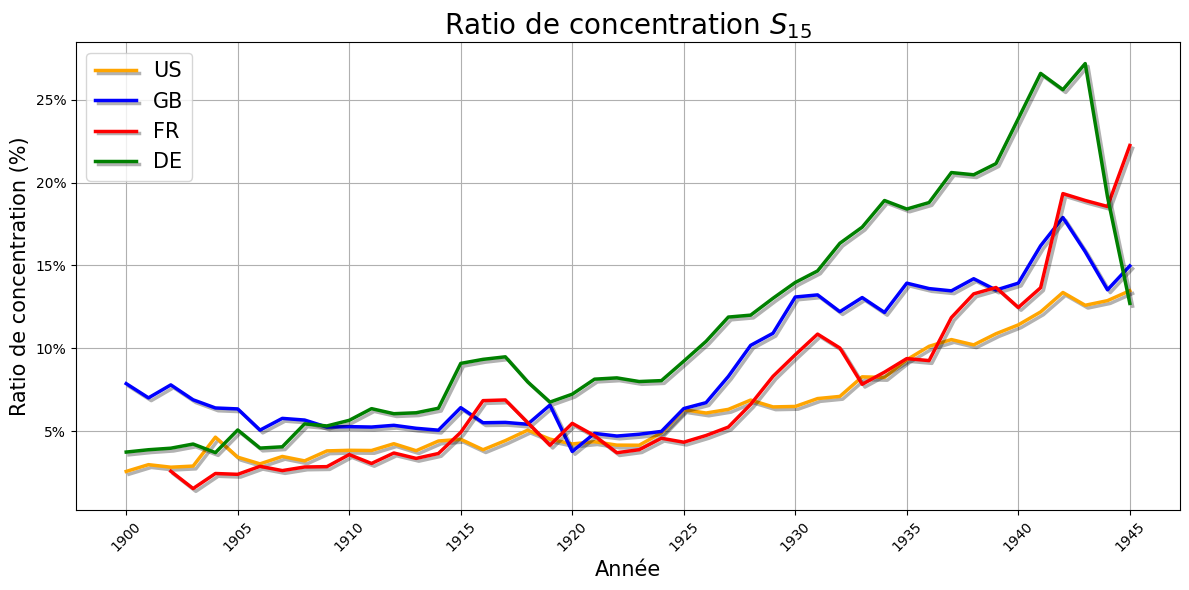

In [10]:
import matplotlib.patheffects as patheffects
plt.figure(figsize=(12, 6))
colors = {'US': 'orange', 'GB': 'blue', 'FR': 'red', 'DE': 'green'} #We try to always use the same colors for the same countries
for country, values in concentration.items():
    plt.plot(range(1900, 1946), values, label=country, color=colors[country], markersize=4)
plt.title('Ratio de concentration $S_{15}$', fontweight='normal', fontsize=20)
plt.xlabel('Année', fontsize=15)
plt.xticks(range(1900, 1946, 5), rotation=45)
for line in plt.gca().lines:
    line.set_path_effects([patheffects.SimpleLineShadow(), patheffects.Normal()])
    line.set_linewidth(2.5)
plt.legend(fontsize=15)
plt.gca().set_ylabel('Ratio de concentration (%)', fontsize=15)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0f}%'.format(y * 100)))
plt.grid(True)

plt.tight_layout()

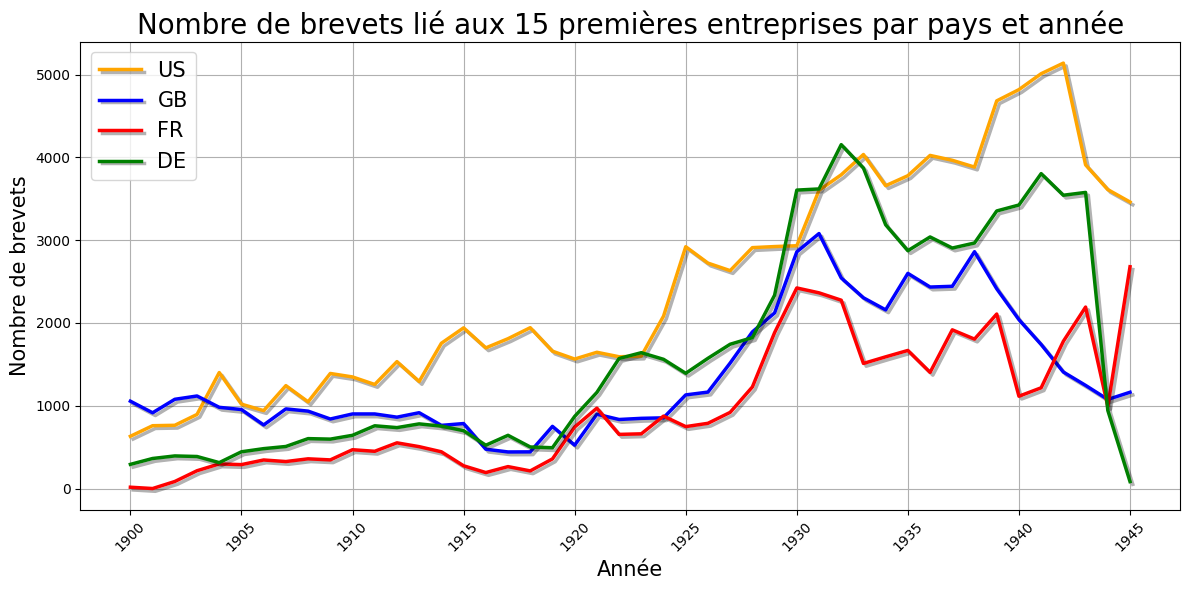

In [11]:

import matplotlib.patheffects as patheffects
plt.figure(figsize=(12, 6))
colors = {'US': 'orange', 'GB': 'blue', 'FR': 'red', 'DE': 'green'}
for country, values in top15.items():
    plt.plot(range(1900, 1946), values, label=country, color=colors[country], markersize=4)
plt.title('Nombre de brevets lié aux 15 premières entreprises par pays et année', fontweight='normal', fontsize=20)
plt.xlabel('Année', fontsize=15)
plt.xticks(range(1900, 1946, 5), rotation=45)
for line in plt.gca().lines:
    line.set_path_effects([patheffects.SimpleLineShadow(), patheffects.Normal()])
    line.set_linewidth(2.5)
plt.legend(fontsize=15)
plt.gca().set_ylabel('Nombre de brevets', fontsize=15)
#plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0f}%'.format(y * 100)))
plt.grid(True)

plt.tight_layout()
